In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset/data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset/balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

# Remove empty values
df_1 = df_1.dropna(subset=['body', 'subject', 'label'])
df_2 = df_2.dropna(subset=['body'])
df_3 = df_3.dropna(subset=['body', 'label'])

# Add missing columns
df_2['sender'] = ''
df_2['subject'] = ''
df_3['sender'] = ''
df_3['subject'] = ''

# Combine datasets
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df = df[df['label'].isin([0, 1])]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['cleaned_sender'] = df['sender'].apply(clean_text)
df['cleaned_subject'] = df['subject'].apply(clean_text)
df['cleaned_body'] = df['body'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


all multinomial Naive Bayes

Accuracy: 0.9572670207629165
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      6046
           1       0.99      0.92      0.96      6380

    accuracy                           0.96     12426
   macro avg       0.96      0.96      0.96     12426
weighted avg       0.96      0.96      0.96     12426



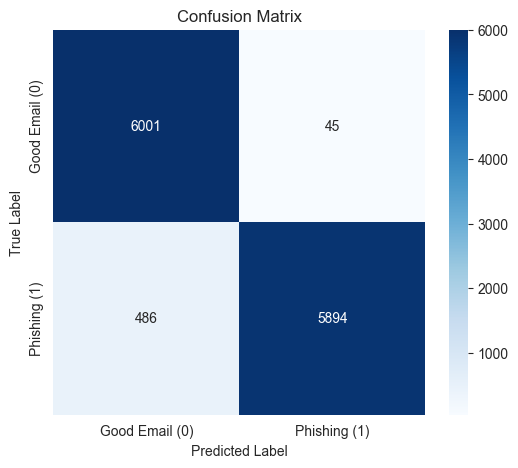

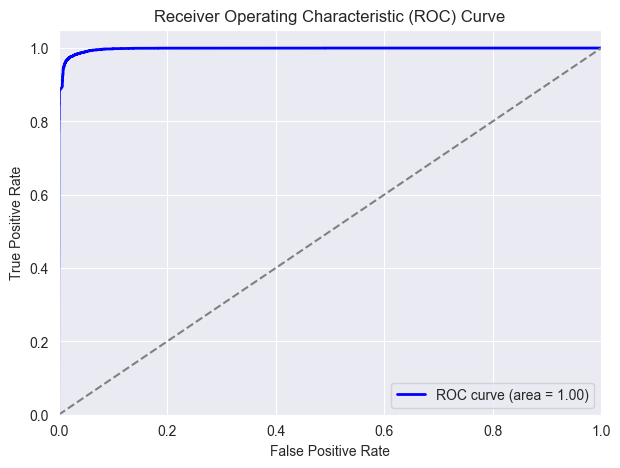

In [2]:
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.67      0.80         3

    accuracy                           0.91        11
   macro avg       0.94      0.83      0.87        11
weighted avg       0.92      0.91      0.90        11



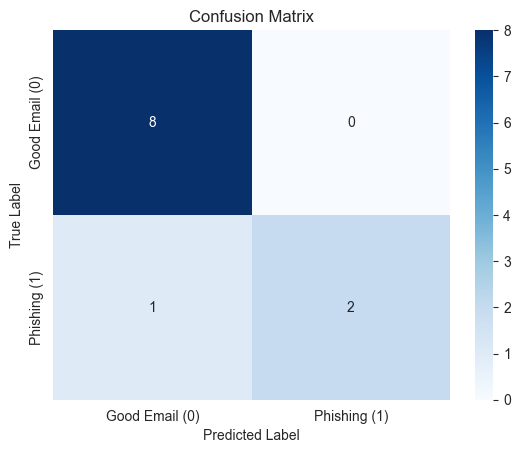

In [3]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = nb_model.predict(X_test_combined)
test_df['phishing_probability'] = nb_model.predict_proba(X_test_combined)[:, 1]

# If you have true labels for evaluation
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

Random Forest

Accuracy: 0.9750523096732657
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      6046
           1       0.99      0.96      0.98      6380

    accuracy                           0.98     12426
   macro avg       0.98      0.98      0.98     12426
weighted avg       0.98      0.98      0.98     12426



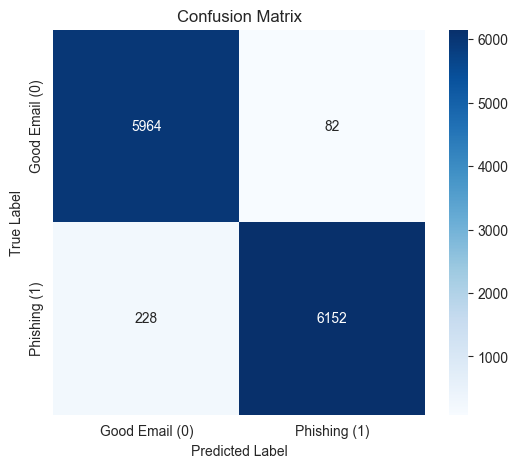

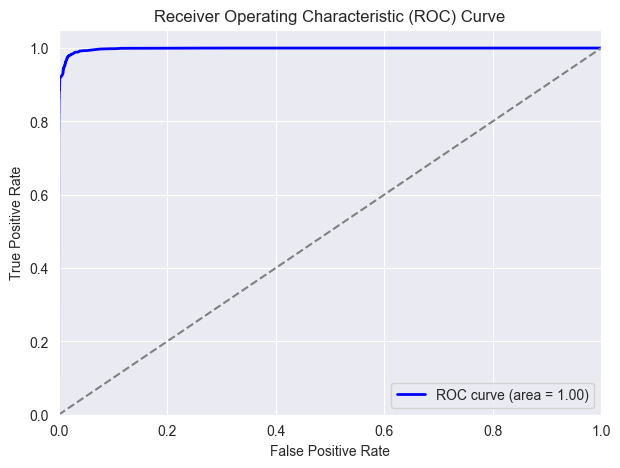

In [4]:
from sklearn.ensemble import RandomForestClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Random Forest Model, trees=50
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.36363636363636365
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.00      0.00      0.00         3

    accuracy                           0.36        11
   macro avg       0.29      0.25      0.27        11
weighted avg       0.42      0.36      0.39        11



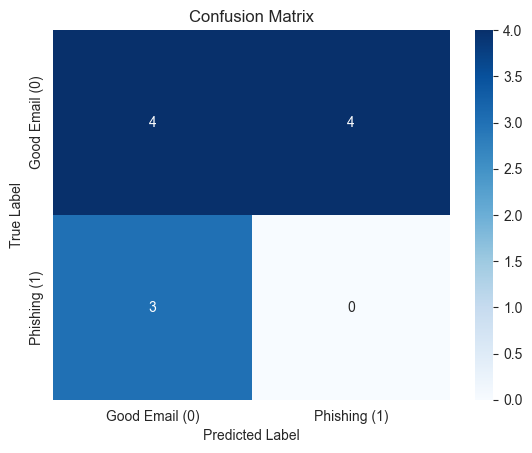

In [5]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = rf_model.predict(X_test_combined)
test_df['phishing_probability'] = rf_model.predict_proba(X_test_combined)[:, 1]

# If you have true labels for evaluation
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

xgboost

C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:01:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9793175599549332
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      6046
           1       0.97      0.99      0.98      6380

    accuracy                           0.98     12426
   macro avg       0.98      0.98      0.98     12426
weighted avg       0.98      0.98      0.98     12426



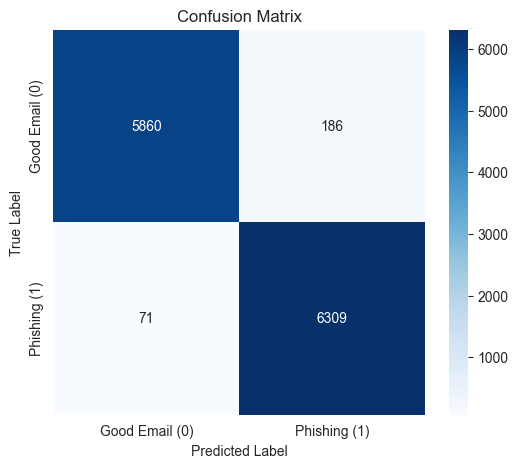

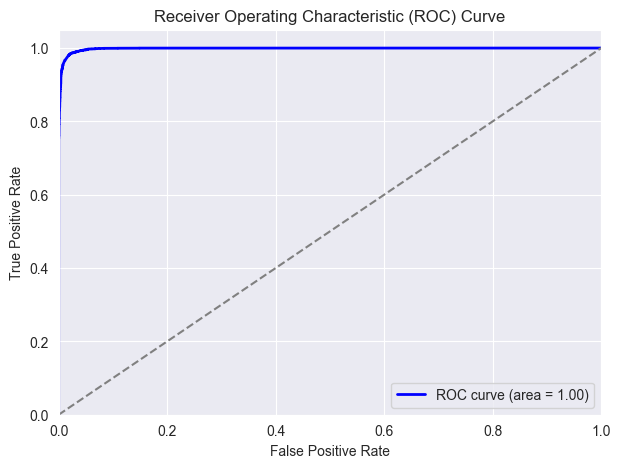

In [6]:
from xgboost import XGBClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train XGBoost Model, disable the internal label encoder and avoid any related warnings or errors, logarithmic loss for classification problems
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.60      1.00      0.75         3

    accuracy                           0.82        11
   macro avg       0.80      0.88      0.80        11
weighted avg       0.89      0.82      0.83        11



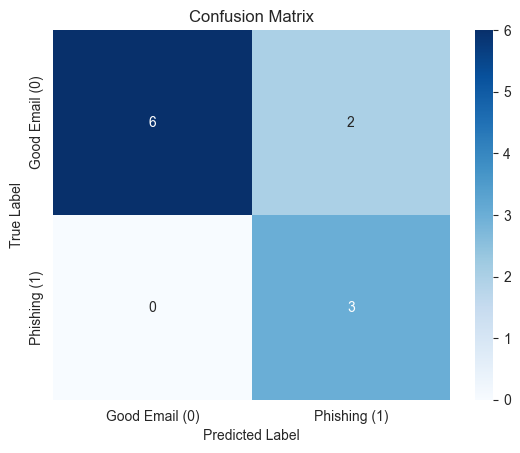

In [7]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = xgb_model.predict(X_test_combined)
test_df['phishing_probability'] = xgb_model.predict_proba(X_test_combined)[:, 1]

# If you have true labels for evaluation
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

Logistic Regression

Accuracy: 0.9880090133590858
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      6046
           1       0.98      0.99      0.99      6380

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426



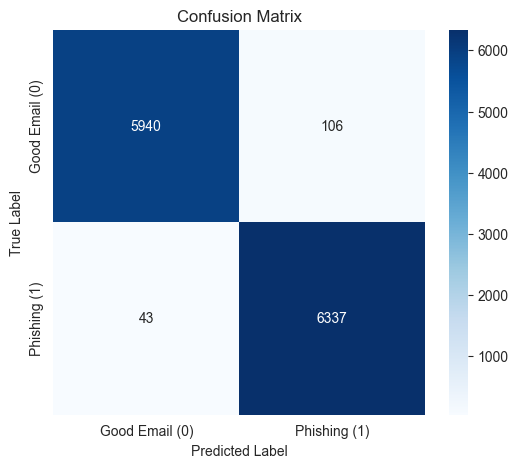

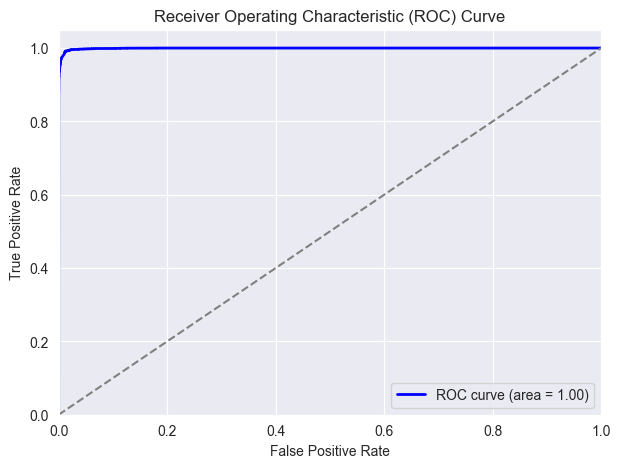

In [8]:
from sklearn.linear_model import LogisticRegression
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Predictions
y_pred = logreg_model.predict(X_test)
y_pred_proba = logreg_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.5454545454545454
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.33      0.67      0.44         3

    accuracy                           0.55        11
   macro avg       0.57      0.58      0.53        11
weighted avg       0.67      0.55      0.57        11



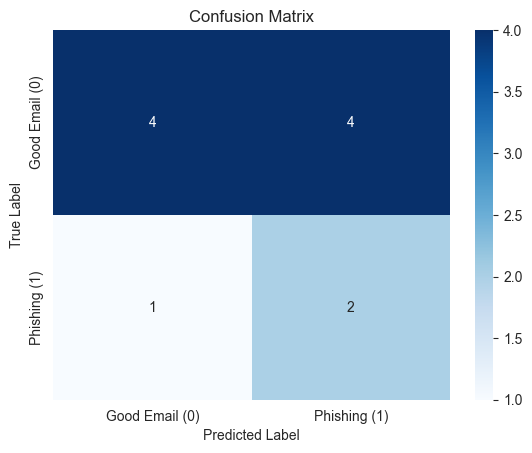

In [9]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = logreg_model.predict(X_test_combined)
test_df['phishing_probability'] = logreg_model.predict_proba(X_test_combined)[:, 1]

# If you have true labels for evaluation
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

K-Nearest Neighbors

Accuracy: 0.9148559472074682
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      6046
           1       0.92      0.91      0.92      6380

    accuracy                           0.91     12426
   macro avg       0.91      0.91      0.91     12426
weighted avg       0.91      0.91      0.91     12426



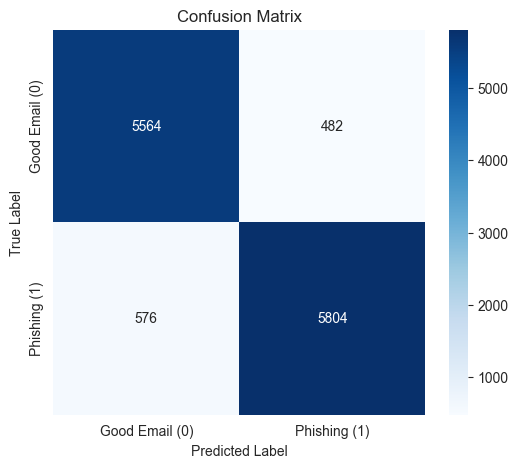

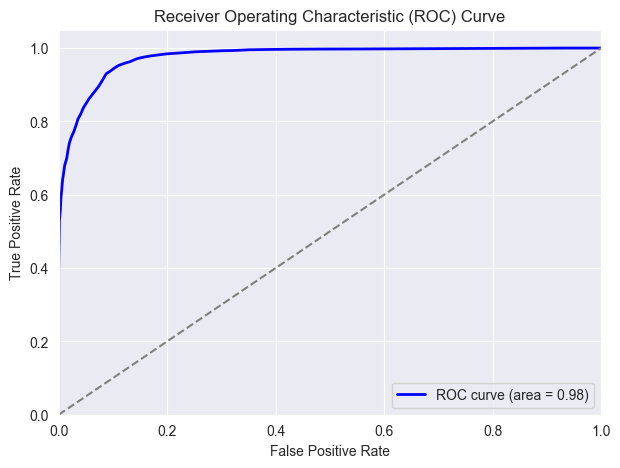

In [10]:
from sklearn.neighbors import KNeighborsClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

#  consider the 25 nearest neighbors when determining the class of a new data point
knn_model = KNeighborsClassifier(n_neighbors=50)
knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6363636363636364
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.43      1.00      0.60         3

    accuracy                           0.64        11
   macro avg       0.71      0.75      0.63        11
weighted avg       0.84      0.64      0.65        11



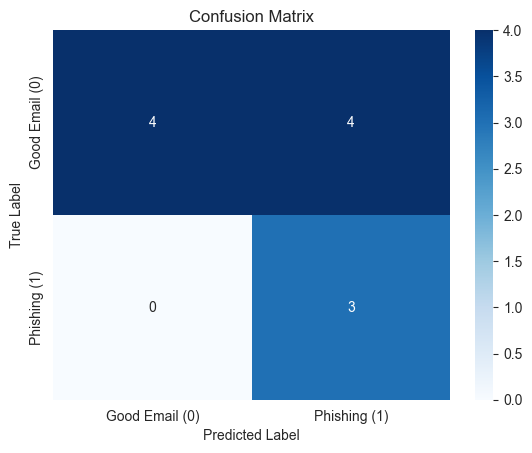

In [11]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = knn_model.predict(X_test_combined)
test_df['phishing_probability'] = knn_model.predict_proba(X_test_combined)[:, 1]

# If you have true labels for evaluation
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

AdaBoost

Accuracy: 0.8420247867374859
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82      6046
           1       0.80      0.92      0.86      6380

    accuracy                           0.84     12426
   macro avg       0.85      0.84      0.84     12426
weighted avg       0.85      0.84      0.84     12426



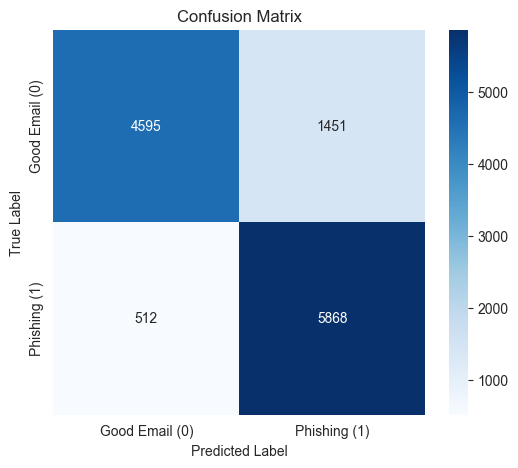

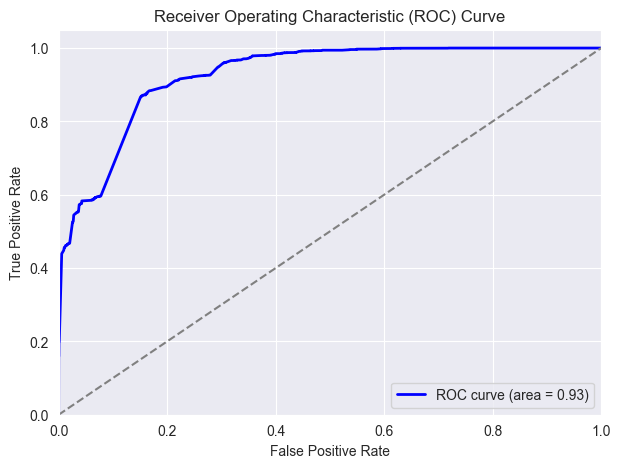

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# DecisionTreeClassifier with max_depth=1 (weak learner), tree size =50
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# Predictions
y_pred = ada_model.predict(X_test)
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.60      1.00      0.75         3

    accuracy                           0.82        11
   macro avg       0.80      0.88      0.80        11
weighted avg       0.89      0.82      0.83        11



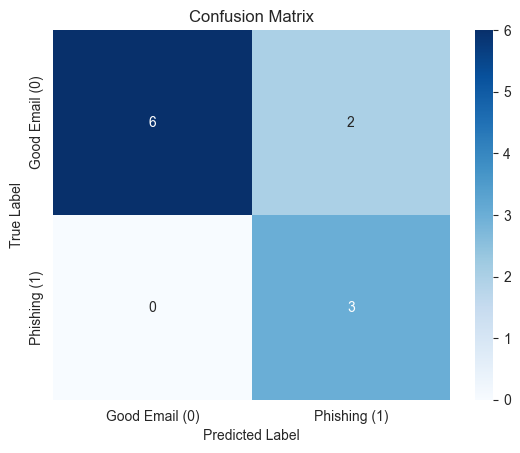

In [13]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = ada_model.predict(X_test_combined)
test_df['phishing_probability'] = ada_model.predict_proba(X_test_combined)[:, 1]

# If you have true labels for evaluation
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)